In [238]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [239]:
PATH = r'/Users/teguhsatya/Desktop/36'
retina = {}
ACCEPT = ('jpg', 'png', 'JPG', 'JPEG')
for files in os.listdir(PATH):
    print(f'reading {os.path.join(PATH, files)}')
    if files.split('.')[1] in ACCEPT:
        fname = files.split('.')[0]
        retina[fname] = cv2.imread(os.path.join(PATH, files))
        retina[fname] = cv2.cvtColor(retina[fname], cv2.COLOR_BGR2RGB)

reading /Users/teguhsatya/Desktop/36/RET014OD.jpg
reading /Users/teguhsatya/Desktop/36/RET030OS.jpg
reading /Users/teguhsatya/Desktop/36/RET030OD.jpg
reading /Users/teguhsatya/Desktop/36/RET015OS.jpg
reading /Users/teguhsatya/Desktop/36/RET008OS.jpg
reading /Users/teguhsatya/Desktop/36/RET004OS.jpg
reading /Users/teguhsatya/Desktop/36/RET026OD.jpg
reading /Users/teguhsatya/Desktop/36/RET026OS.jpg
reading /Users/teguhsatya/Desktop/36/RET002OS.jpg
reading /Users/teguhsatya/Desktop/36/RET002OD.jpg
reading /Users/teguhsatya/Desktop/36/RET007OS.jpg
reading /Users/teguhsatya/Desktop/36/RET007OD.jpg
reading /Users/teguhsatya/Desktop/36/RET023OD.jpg
reading /Users/teguhsatya/Desktop/36/RET023OS.jpg
reading /Users/teguhsatya/Desktop/36/RET021OS.jpg
reading /Users/teguhsatya/Desktop/36/RET021OD.jpg
reading /Users/teguhsatya/Desktop/36/RET025OS.jpg
reading /Users/teguhsatya/Desktop/36/RET025OD.jpg
reading /Users/teguhsatya/Desktop/36/RET018OS.jpg
reading /Users/teguhsatya/Desktop/36/RET018OD.jpg


In [240]:
def display_all(imgs, subs=(10,10), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(15, 18))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            # axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(10,10), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(15, 18))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

def resize_all(imgs, factor=50):
    resized_imgs = {}
    for img in imgs:
        resized_imgs[img] = cv2.resize(imgs[img], 
                                       (int(imgs[img].shape[1]*factor/100), 
                                        int(imgs[img].shape[0]*factor/100)), 
                                       cv2.INTER_AREA)
    return resized_imgs

In [241]:
rsz_imgs = resize_all(retina)

In [242]:
rsz_imgs['RET014OD'].shape

(967, 1288, 3)

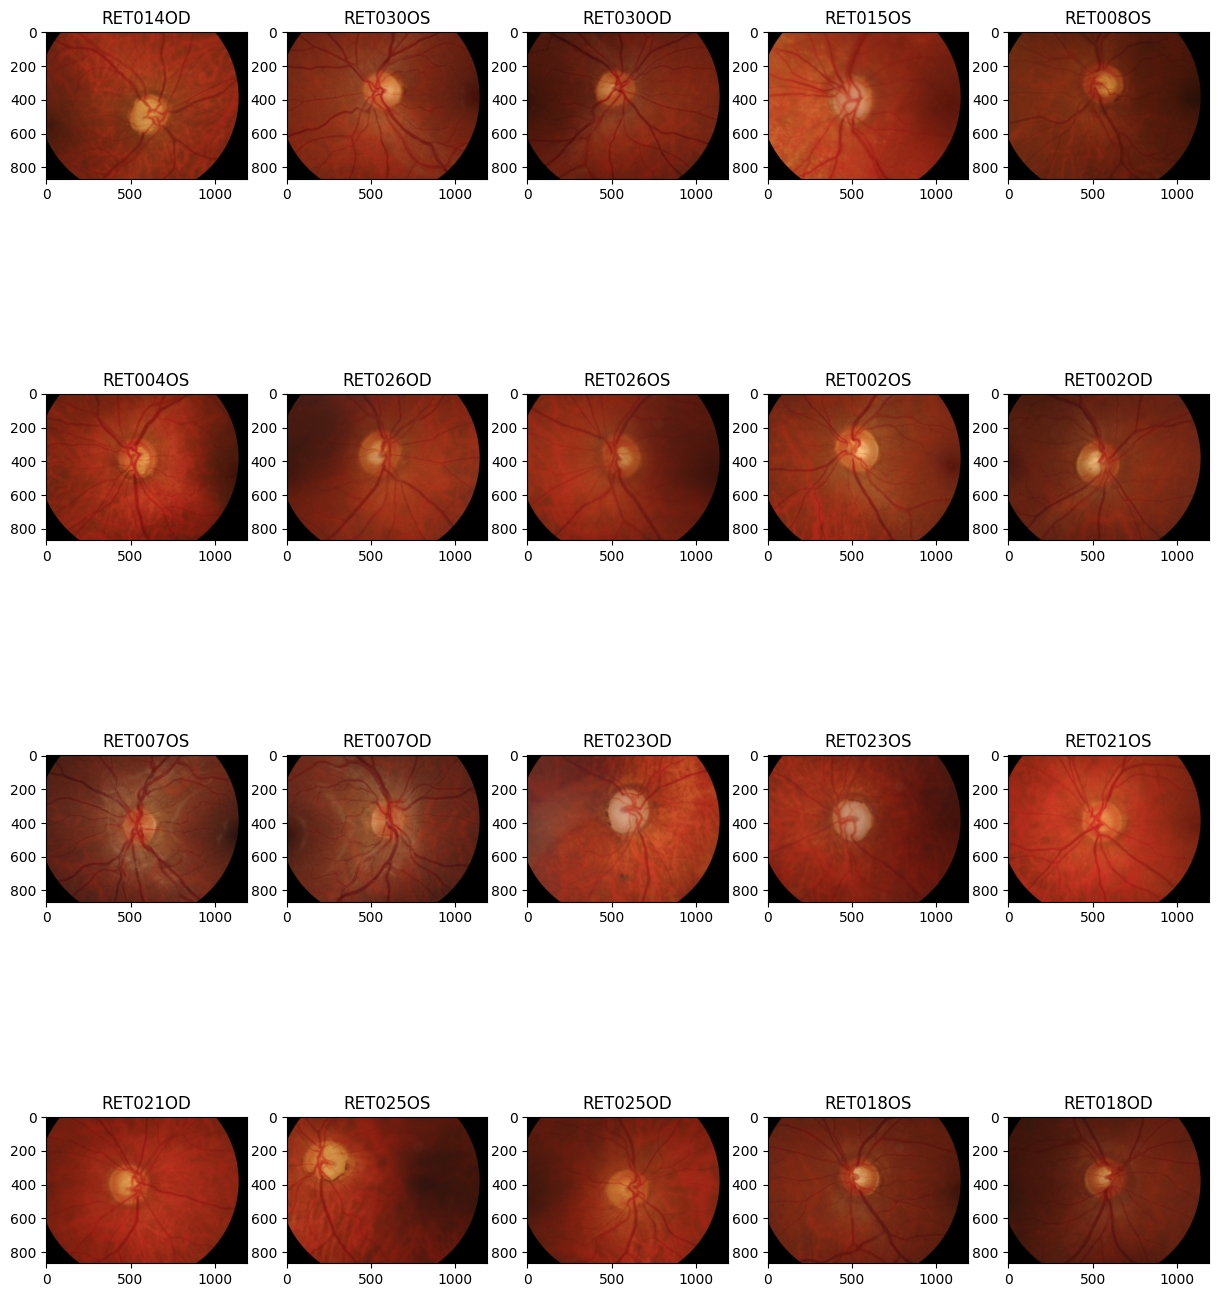

In [243]:
cropped = {}
for img in rsz_imgs:
    cropped[img] = rsz_imgs[img][100:, 100:]
display_all(cropped, (4,5))

In [244]:
def preprocess(imgs):
    lab = cv2.cvtColor(imgs, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(1.5, (50, 50))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return cv2.medianBlur(rgb, 45)

def get_roi(imgs):
    rois = {}
    p = {}
    for img in imgs:
        pre = preprocess(imgs[img])
        gray = cv2.cvtColor(pre, cv2.COLOR_RGB2GRAY)
        xmax = cv2.minMaxLoc(gray)[3][0]
        ymax = cv2.minMaxLoc(gray)[3][1]
        # s = 150
        # coord1 = (xmax-400, ymax-450)
        # coord2 = (xmax+400, ymax+450)
        # color = (0, 0, 255)
        # t = 5
        cropped = Image.fromarray(imgs[img])
        cropped_res = cropped.crop((xmax-200, ymax-200, xmax+200, ymax+200))
        rois[img] = np.array(cropped_res)
    return rois

In [245]:
all_roi = get_roi(cropped)

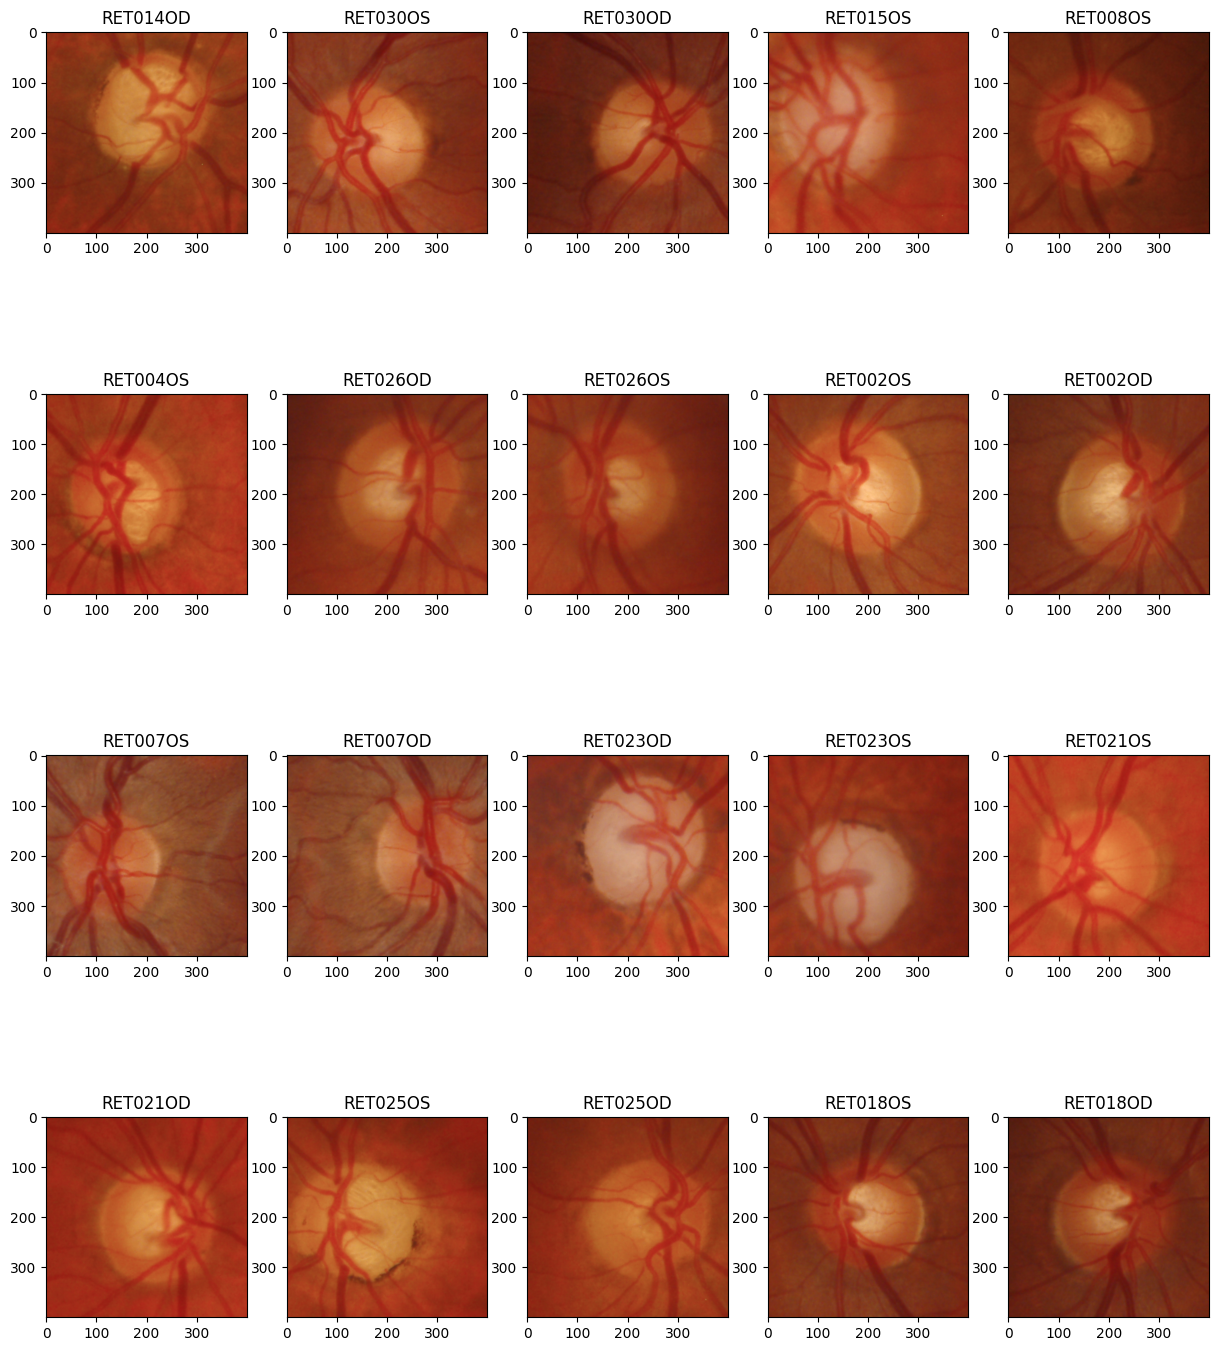

In [246]:
display_all(all_roi, (4,5))

In [273]:
def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

def get_which_ellipse(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    ellipse = cv2.fitEllipse(contours[cont_idx])
    return ellipse

def remove_vessels(imgs):
    no_vsl = {}
    for img in imgs:
        g = imgs[img][:,:,1].copy()
        g_inv = 255-g
        g_gamma = adjust_gamma(g_inv.copy(), 1.5)
        g_gauss = cv2.GaussianBlur(g_gamma, (15,15),0)
        ret, th = cv2.threshold(g_gauss.copy(),0,255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        no_vsl[img] = cv2.inpaint(imgs[img], th, 2, cv2.INPAINT_TELEA)
    display_all(no_vsl, (4,5), use_gray=True)
    return no_vsl


def extract_od(imgs):
    # tidak harus ada drawn_roi
    p = {}
    drawn_roi = {}
    ods = {}
    for img in imgs:
        red = imgs[img][:,:,0]
        gmcr = adjust_gamma(red, 5.0)
        clahe = cv2.createCLAHE(5, (8,8))
        gmclahe = clahe.apply(gmcr)
        gmcr_bl = cv2.GaussianBlur(gmclahe, (15,15), 0)
        erosion = cv2.erode(gmcr_bl.copy(), kernel=np.ones((10,10), np.uint8))
        dilation = cv2.dilate(erosion, kernel=np.ones((10,10), np.uint8))
        ret2, p[img] = cv2.threshold(dilation,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         cont, hcy = cv2.findContours(th2.copy(), 
#                                      cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         ellipse = get_which_ellipse(cont)
            
#         od = np.zeros_like(th2, dtype='uint8')
#         cv2.ellipse(od, ellipse, (255, 255, 255), -1)
#         ods[img] = od
#         drawn_roi[img] = ellipse

#     return drawn_roi, ods
    display_all(p, (4,5), use_gray=True)
    return None, None
        



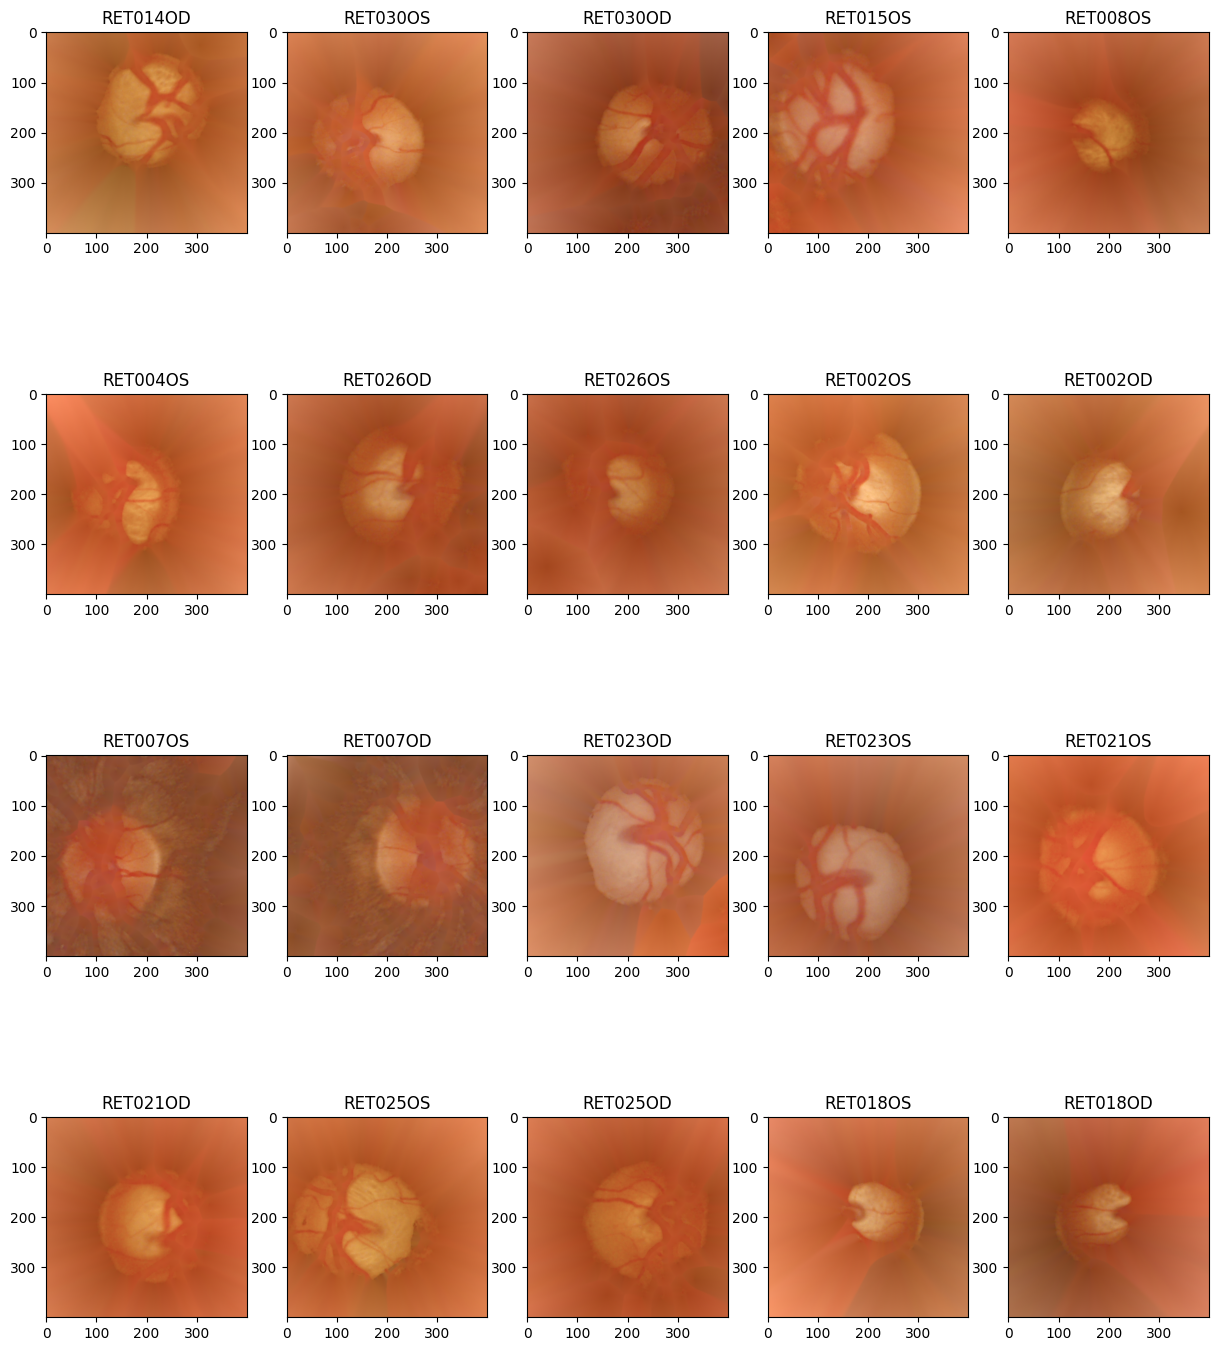

In [274]:
no_vsl = remove_vessels(all_roi)

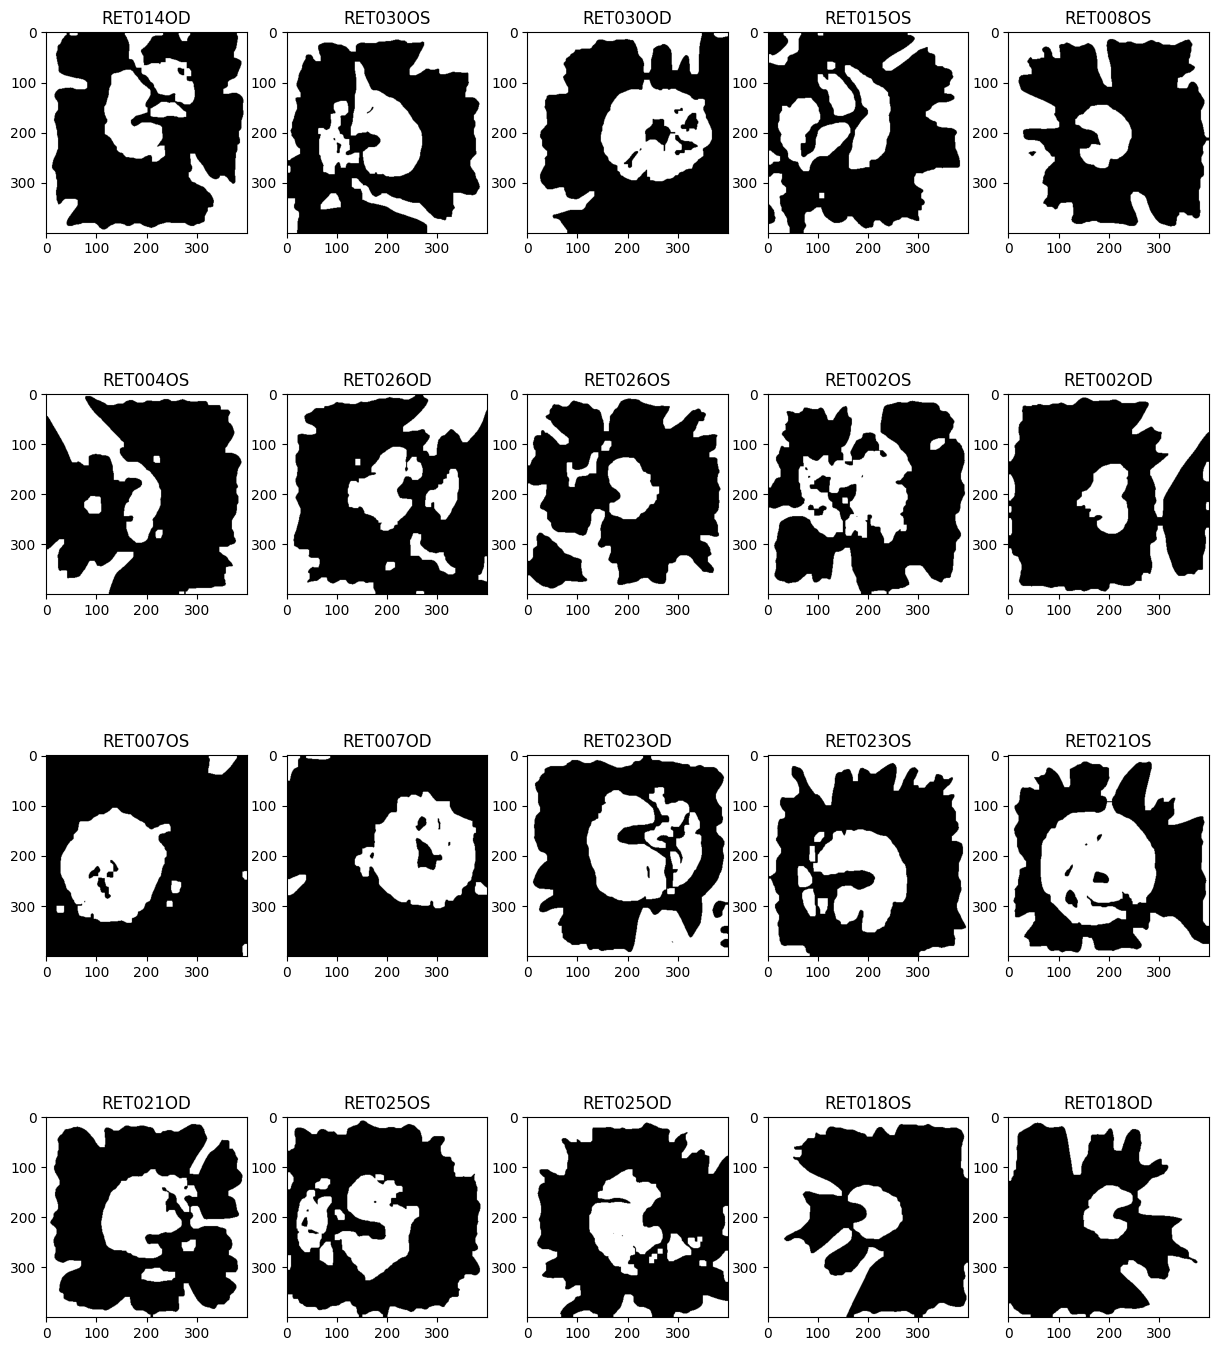

In [275]:
od_line, all_od = extract_od(no_vsl)